# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

##For local windows implementation
env = UnityEnvironment(file_name='C:/Users/adamb/OneDrive/Documents/Udacity Reinforcement Learning/3. Policy Base Methods/p2_continous_control/Reacher_Windows_x86_64/Reacher')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# 5. Initial Implementation 

In [ ]:
##Not required for local implementations
#!pip -q install ./python

In [1]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
import datetime

from unityagents import UnityEnvironment
from model import Actor, Critic
from ddpg_agent import Agent, OUNoise, ReplayBuffer

In [2]:
%matplotlib inline

In [3]:
##Instantiate environment
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

##For local windows implementation
env = UnityEnvironment(file_name='C:/Users/adamb/OneDrive/Documents/Udacity Reinforcement Learning/3. Policy Base Methods/p2_continous_control/Reacher_Windows_x86_64/Reacher')


# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
##Get 'environment' variables
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

Number of agents: 1
Size of each action: 4


In [6]:
##Instantiate Agent
agent = Agent(state_size = state_size, action_size = action_size, random_seed=42)

In [7]:
def ddpg_train(n_episodes=200, max_t=200, print_every=10):
    scores_deque = deque(maxlen=print_every)
    scores = []
    reward_avg = []
    
    scores_avg = []
    
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        #states = env_info.vector_observations
        score = 0
        #score = np.zeros(num_agents)

        reward_temp = 0
        steps = 0
        #print(i_episode)
        
        for t in range(max_t):
            steps += 1
            ##Determine action to take with clipping
            action = agent.act(state, add_noise=True)
            #actions = agent.act(states, add_noise=False)
            
            ##Execute action
            env_info = env.step(action)[brain_name]
            #env_info = env.step(actions)[brain_name]
            
            ##Get results of action
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                  
            done = env_info.local_done[0]  
            #next_states = env_info.vector_observations
            #rewards = env_info.rewards
            #dones = env_info.local_done
        
            ##Update agent
            agent.step(state, action, reward, next_state, done)
            #agent.step(states, actions, rewards, next_states, dones)
            
            ##Save scores
            score += reward
            #score += env_info.rewards
            
            state = next_state
            #states = next_states
            
            if done:
                break
            #if np.any(dones):
            #    break
        
        print(datetime.datetime.now())
        print('Score: ' + str(score))
        reward_avg.append(score / steps)
        
        #reward_avg += [sum(reward_temp) / len(reward_temp)]
        
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        scores_avg.append(np.mean(scores_deque))
        #print(reward_avg)
        print()
        

    return scores, reward_avg, scores_avg

In [8]:
scores, reward_avg, scores_avg = ddpg_train(n_episodes=500, max_t=2000, print_every=20)

C:\Users\adamb\Anaconda3\envs\testenv4\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\adamb\OneDrive\Documents\Udacity Reinforcement Learning\3. Policy Base Methods\p2_continous_control\ddpg_agent.py:97: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


2019-12-19 19:06:45.702370
Score: 0.0
Episode 1	Average Score: 0.00
2019-12-19 19:07:07.109225
Score: 0.5999999865889549
Episode 2	Average Score: 0.30
2019-12-19 19:07:28.586323
Score: 0.0
Episode 3	Average Score: 0.20
2019-12-19 19:07:50.051859
Score: 0.0
Episode 4	Average Score: 0.15
2019-12-19 19:08:11.579322
Score: 0.0
Episode 5	Average Score: 0.12
2019-12-19 19:08:33.109940
Score: 0.2799999937415123
Episode 6	Average Score: 0.15
2019-12-19 19:08:54.734463
Score: 0.1599999964237213
Episode 7	Average Score: 0.15
2019-12-19 19:09:16.306072
Score: 0.2699999939650297
Episode 8	Average Score: 0.16
2019-12-19 19:09:37.972601
Score: 0.0
Episode 9	Average Score: 0.15
2019-12-19 19:09:59.565398
Score: 0.8599999807775021
Episode 10	Average Score: 0.22
2019-12-19 19:10:21.278084
Score: 1.0099999774247408
Episode 11	Average Score: 0.29
2019-12-19 19:10:43.088320
Score: 0.36999999172985554
Episode 12	Average Score: 0.30
2019-12-19 19:11:04.862936
Score: 0.18999999575316906
Episode 13	Average Sc

2019-12-19 19:43:57.065849
Score: 0.7399999834597111
Episode 101	Average Score: 0.96
2019-12-19 19:44:20.261303
Score: 0.7799999825656414
Episode 102	Average Score: 0.97
2019-12-19 19:44:43.503056
Score: 0.2899999935179949
Episode 103	Average Score: 0.96
2019-12-19 19:45:06.784598
Score: 1.289999971166253
Episode 104	Average Score: 0.92
2019-12-19 19:45:30.117103
Score: 0.5799999870359898
Episode 105	Average Score: 0.95
2019-12-19 19:45:53.375128
Score: 0.6599999852478504
Episode 106	Average Score: 0.95
2019-12-19 19:46:16.585187
Score: 1.6099999640136957
Episode 107	Average Score: 0.99
2019-12-19 19:46:39.745524
Score: 0.7399999834597111
Episode 108	Average Score: 1.00
2019-12-19 19:47:02.992569
Score: 1.7899999599903822
Episode 109	Average Score: 0.99
2019-12-19 19:47:26.087463
Score: 0.8899999801069498
Episode 110	Average Score: 0.93
2019-12-19 19:47:49.627271
Score: 1.6399999633431435
Episode 111	Average Score: 0.92
2019-12-19 19:48:12.747218
Score: 1.3599999696016312
Episode 112	A

2019-12-19 20:21:55.887703
Score: 0.13999999687075615
Episode 199	Average Score: 0.78
2019-12-19 20:22:19.489835
Score: 1.219999972730875
Episode 200	Average Score: 0.72

2019-12-19 20:22:42.752577
Score: 0.5799999870359898
Episode 201	Average Score: 0.75
2019-12-19 20:23:06.065607
Score: 0.42999999038875103
Episode 202	Average Score: 0.73
2019-12-19 20:23:29.343885
Score: 1.0599999763071537
Episode 203	Average Score: 0.78
2019-12-19 20:23:52.670523
Score: 1.1599999740719795
Episode 204	Average Score: 0.71
2019-12-19 20:24:15.999580
Score: 2.5299999434500933
Episode 205	Average Score: 0.75
2019-12-19 20:24:39.314317
Score: 1.0499999765306711
Episode 206	Average Score: 0.78
2019-12-19 20:25:02.694036
Score: 0.7999999821186066
Episode 207	Average Score: 0.76
2019-12-19 20:25:25.907819
Score: 0.7199999839067459
Episode 208	Average Score: 0.75
2019-12-19 20:25:49.047864
Score: 1.4699999671429396
Episode 209	Average Score: 0.80
2019-12-19 20:26:12.274719
Score: 1.169999973848462
Episode 210

2019-12-19 20:59:58.774069
Score: 0.0
Episode 297	Average Score: 0.71
2019-12-19 21:00:21.998491
Score: 0.4899999890476465
Episode 298	Average Score: 0.74
2019-12-19 21:00:45.366506
Score: 0.979999978095293
Episode 299	Average Score: 0.74
2019-12-19 21:01:08.893735
Score: 0.8999999798834324
Episode 300	Average Score: 0.76

2019-12-19 21:01:32.274122
Score: 1.0199999772012234
Episode 301	Average Score: 0.74
2019-12-19 21:01:55.651955
Score: 0.0
Episode 302	Average Score: 0.70
2019-12-19 21:02:18.965764
Score: 1.1599999740719795
Episode 303	Average Score: 0.70
2019-12-19 21:02:42.254620
Score: 0.5599999874830246
Episode 304	Average Score: 0.70
2019-12-19 21:03:05.616819
Score: 0.5299999881535769
Episode 305	Average Score: 0.69
2019-12-19 21:03:28.879350
Score: 0.7099999841302633
Episode 306	Average Score: 0.68
2019-12-19 21:03:52.100812
Score: 0.8099999818950891
Episode 307	Average Score: 0.64
2019-12-19 21:04:15.363999
Score: 0.789999982342124
Episode 308	Average Score: 0.61
2019-12-19 

2019-12-19 21:37:48.605802
Score: 0.0
Episode 395	Average Score: 0.66
2019-12-19 21:38:11.261814
Score: 0.5299999881535769
Episode 396	Average Score: 0.68
2019-12-19 21:38:34.002550
Score: 0.0
Episode 397	Average Score: 0.62
2019-12-19 21:38:56.674693
Score: 0.6399999856948853
Episode 398	Average Score: 0.60
2019-12-19 21:39:19.340452
Score: 0.5599999874830246
Episode 399	Average Score: 0.62
2019-12-19 21:39:42.036560
Score: 0.0
Episode 400	Average Score: 0.60

2019-12-19 21:40:04.723593
Score: 0.0
Episode 401	Average Score: 0.58
2019-12-19 21:40:27.359423
Score: 1.7599999606609344
Episode 402	Average Score: 0.63
2019-12-19 21:40:50.871025
Score: 0.669999985024333
Episode 403	Average Score: 0.60
2019-12-19 21:41:13.673563
Score: 0.30999999307096004
Episode 404	Average Score: 0.61
2019-12-19 21:41:36.374705
Score: 0.0
Episode 405	Average Score: 0.59
2019-12-19 21:41:59.052459
Score: 0.0
Episode 406	Average Score: 0.56
2019-12-19 21:42:21.673972
Score: 0.9599999785423279
Episode 407	Aver

2019-12-19 22:15:14.843762
Score: 1.149999974295497
Episode 494	Average Score: 0.65
2019-12-19 22:15:37.506751
Score: 1.4199999682605267
Episode 495	Average Score: 0.69
2019-12-19 22:16:00.196121
Score: 0.41999999061226845
Episode 496	Average Score: 0.69
2019-12-19 22:16:22.817229
Score: 0.8999999798834324
Episode 497	Average Score: 0.72
2019-12-19 22:16:45.507154
Score: 0.9299999792128801
Episode 498	Average Score: 0.70
2019-12-19 22:17:08.283156
Score: 0.5699999872595072
Episode 499	Average Score: 0.70
2019-12-19 22:17:30.971266
Score: 0.9399999789893627
Episode 500	Average Score: 0.72



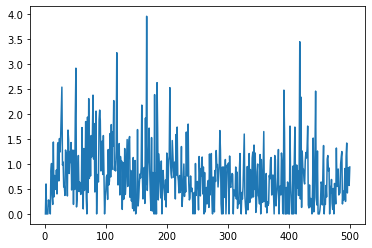

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)

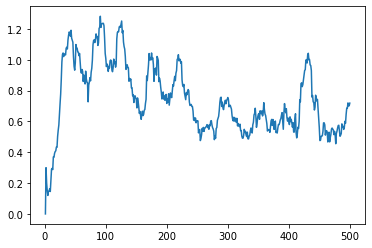

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_avg)+1), scores_avg)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()